# Introduction to Reinforcement Learning Course - Assignment 2
Group Members: Iulia-Elena Teodorescu, Adnan Al Medawer, Konstantinos Tantoulas, Likhith Bedara Agrahara Venkateshamurthy

# Import libraries

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import time

# Define DQN model

In [2]:
class DQN(nn.Module):
    def __init__(self, lr,state_size, n_actions, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        """
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, n_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x) 
        return actions


# Define Experience Replay Buffer

In [3]:
class ReplayBuffer:

    def __init__(self, n_actions, buffer_size, batch_size, seed):

        self.n_actions = n_actions
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert to torch tensors
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)    

In [4]:
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the target network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class Agent():

    def __init__(self, state_size, n_actions, seed):

        self.state_size = state_size
        self.n_actions = n_actions
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_policy = DQN(LR, state_size, n_actions, seed)#.to(device)
        self.qnetwork_target = DQN(LR, state_size, n_actions, seed)#.to(device)

        # Replay memory
        self.memory = ReplayBuffer(n_actions, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        """Store experience and perform learning."""
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            self.learn(self.memory.sample(), GAMMA)


    def select_action(self, state, eps=0.):
        """Choose an action based on epsilon-greedy policy."""
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            action_values = self.qnetwork_policy(state)
        # Epsilon-greedy action selection
        if np.random.rand() > eps:
            action = torch.argmax(action_values).item()
        else:
            action = np.random.randint(self.n_actions)
        return action

                   
    def learn(self, experiences, gamma):
        """Update Q-network parameters using a batch of experience tuples."""
        states, actions, rewards, next_states, dones = experiences

        # Compute target Q values for the current state
        with torch.no_grad():
            Q_targets_next = self.qnetwork_target(next_states).max(1, keepdim=True)[0]
            Q_targets = rewards + gamma * Q_targets_next * (1 - dones)
        
        # Compute the predicted Q values for the chosen actions
        Q_expected = self.qnetwork_policy(states).gather(1, actions)

        # Update policy Q-network
        loss = F.mse_loss(Q_expected, Q_targets)
        self.qnetwork_policy.optimizer.zero_grad()
        loss.backward()
        self.qnetwork_policy.optimizer.step()

        # Update target Q-network
        self.update_network(self.qnetwork_policy, self.qnetwork_target, TAU)

    def update_network(self, local_model, target_model, tau):
        """ Update target model parameters.
        θ_target = τ*θ_policy + (1 - τ)*θ_target
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Train the Agent with DQN

In [ ]:
def train(agent, env, n_episodes=2000, max_t=1000, eps=1.0, eps_min=0.01, eps_decay=0.995):
    """Train the agent using Deep Q-Learning."""
    rewards = []                          # List to store total rewards for each episode
    epsilon_values = []                   # List to store epsilon values for each episode
    rewards_window = deque(maxlen=100)    # Last 100 rewards for average reward
    for i_episode in range(1, n_episodes + 1):
        state, info = env.reset()         # Reset environment and get initial state
        score = 0
        for t in range(max_t):           
            action = agent.select_action(state, eps)  # Get action based on epsilon-greedy policy
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)  # Store experience and learn
            state = next_state
            score += reward
            if done:
                break
        
        # Log the total reward and epsilon for this episode
        rewards.append(score)
        epsilon_values.append(eps)
        rewards_window.append(score)  # Add current episode score to the window
        
        eps = max(eps_min, eps_decay * eps) #Decay epsilon
        
        # Print the episode information
        print(f'\rEpisode {i_episode}/{n_episodes}\t Total Reward: {score:.2f}\t Epsilon: {eps:.2f}', end="")
        if i_episode % 100 == 0: # Print average reward for last 100 episodes
            print(f'\rEpisode {i_episode}/{n_episodes}\tAverage Reward: {np.mean(rewards_window):.2f}')
    
    return rewards, epsilon_values


## Evaluate the Agent

In [7]:
def test(agent, env, n_episodes=100, max_t=1000, eps=0.):
    """Test the agent after training."""
    rewards = []  # List to store total rewards for each episode
    for i_episode in range(1, n_episodes + 1):
        state, info = env.reset()  # Reset environment and get initial state
        score = 0
        for t in range(max_t):     # Loop over each time step in the episode
            action = agent.select_action(state, eps)  # Get action based on epsilon-greedy policy
            next_state, reward, done, info, _ = env.step(action)  # Step in the environment
            state = next_state
            score += reward
            if done:
                break
        
        # Log the total reward for this episode
        rewards.append(score)
        print(f'\rTest Episode {i_episode}/{n_episodes}\tTotal Reward: {score:.2f}', end="")
        if i_episode % 10 == 0:
            print(f'\rTest Episode {i_episode}/{n_episodes}\tTotal Reward: {score:.2f}')
    
    return rewards

# Instantiate the Environment and Agent

Initialize the environment in the code cell below.

C:\Users\kosta\AppData\Local\Temp\ipykernel_43232\3324246063.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  states = torch.tensor(states, dtype=torch.float32).to(device)
C:\Users\kosta\AppData\Local\Temp\ipykernel_43232\2034673373.py:52: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(Q_expected, Q_targets)


Episode 100/2000	Average Reward: -205.33psilon: 0.61
Episode 200/2000	Average Reward: -318.81Epsilon: 0.378
Episode 300/2000	Average Reward: -350.34Epsilon: 0.221
Episode 400/2000	Average Reward: -405.94Epsilon: 0.13
Episode 500/2000	Average Reward: -364.45Epsilon: 0.088
Episode 600/2000	Average Reward: -455.79Epsilon: 0.056
Episode 700/2000	Average Reward: -397.34Epsilon: 0.034
Episode 800/2000	Average Reward: -370.71Epsilon: 0.022
Episode 900/2000	Average Reward: -318.21Epsilon: 0.011
Episode 1000/2000	Average Reward: -284.59Epsilon: 0.01
Episode 1100/2000	Average Reward: -250.63Epsilon: 0.01
Episode 1200/2000	Average Reward: -270.06Epsilon: 0.01
Episode 1300/2000	Average Reward: -248.03silon: 0.0101
Episode 1400/2000	Average Reward: -205.69Epsilon: 0.01
Episode 1500/2000	Average Reward: -170.54Epsilon: 0.01
Episode 1600/2000	Average Reward: -158.96Epsilon: 0.01
Episode 1700/2000	Average Reward: -167.25Epsilon: 0.01
Episode 1720/2000	 Total Reward: 206.74	Epsilon: 0.011
Environment s

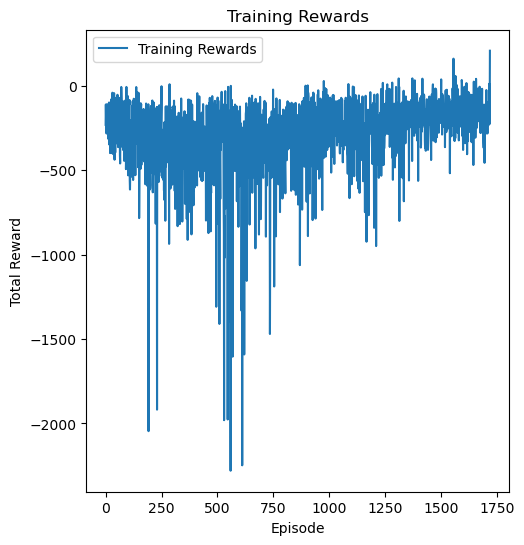

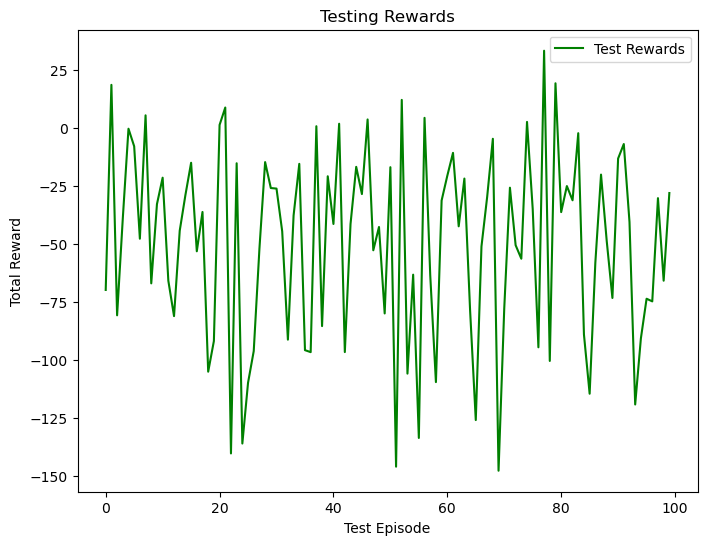

In [8]:
# Initialize environment and agent
env = gym.make('LunarLander-v3', render_mode='human')
agent = Agent(state_size=env.observation_space.shape[0], n_actions=env.action_space.n, seed=0)

# Train the agent and log the total rewards and epsilon
train_rewards, epsilon_values = train(agent, env, n_episodes=2000, eps=1.0, eps_min=0.01, eps_decay=0.995)

# Test the agent after training
test_rewards = test(agent, env, n_episodes=100, max_t=1000, eps=0.)

# Plot the training rewards
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_rewards)), train_rewards, label='Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Rewards')
plt.legend()

# Plot the testing rewards
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(test_rewards)), test_rewards, label='Test Rewards', color='green')
plt.xlabel('Test Episode')
plt.ylabel('Total Reward')
plt.title('Testing Rewards')
plt.legend()
plt.show()

env.close()  # Close the environment after testing
